<b>Partie IA</b>

Imports

In [22]:
!pip install catboost

In [23]:
# Importation des bibliothèques nécessaires
import pandas as pd  # Pour manipuler les données sous forme de DataFrame
import warnings  # Pour gérer les avertissements

# Importation des modules de Scikit-learn pour la transformation des colonnes, pipelines, modèles et évaluation
from sklearn.compose import ColumnTransformer  # Pour appliquer des transformations différentes sur les colonnes
from sklearn.pipeline import Pipeline  # Pour créer des pipelines de transformations et de modèles
from sklearn.preprocessing import StandardScaler  # Pour le prétraitement des données
from sklearn.model_selection import train_test_split  # Pour la division des données et la recherche des hyperparamètres
from sklearn.metrics import accuracy_score, classification_report  # Pour évaluer les performances du modèle
from catboost import CatBoostClassifier  # Classifieur CatBoost

# Ignorer certains avertissements
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
file_path = '/content/drive/MyDrive/fichiersPFE/creditcard_2023.csv'
df_tr = pd.read_csv(file_path)

L'étude des variables sur la partie Big Data nous a permis de voir que certaines corrélations de variables sont plus importantes que d'autres dans le dataset pour les transactions frauduleuse. Car nous ne pouvont pas être 100% sûrs de pouvoir enelever celles qui n'ont pas l'air importantes, nous les gardons.

On teste plusieurs méthodes d'intelligence artificielle pour en trouver une qui est à la fois rapide et efficace.

*Apprentissage supervisé*

In [26]:
# Séparation des données en caractéristiques (X) et cible (y)
X = df_tr.drop('Class', axis=1)
y = df_tr['Class']

In [27]:
# Définir les caractéristiques numériques (exclure les colonnes catégorielles)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [28]:
# Définir le pipeline de transformation pour les colonnes numériques
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

StandardScaler() est un transformateur qui normalise les données en les centrant sur la moyenne 0 et en les réduisant à une échelle unitaire (écart-type 1). Cela est souvent nécessaire avant de passer à des algorithmes d'apprentissage automatique, car certains modèles sont sensibles à l'échelle des données (par exemple, les modèles basés sur la distance comme la régression logistique, SVM, etc.).

In [29]:
# Définir la transformation par colonnes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [30]:
# Définir le modèle
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', CatBoostClassifier(verbose=False))])

In [31]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Entraîner le modèle
model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'V1', 'V2', 'V3', 'V4',
                                                   'V5', 'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28',
                                                   'Amount'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7ee0d9d64af0>)])

In [33]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

In [34]:
# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9996570705027874


On va maintenant afficher le training.

In [35]:
!pip install graphviz


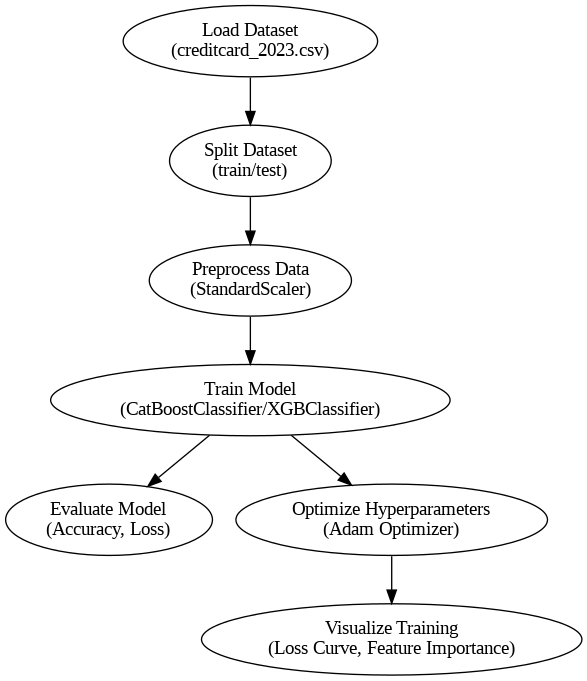

In [36]:

from graphviz import Digraph
from IPython.display import Image, display

# Initialize a directed graph
dot = Digraph()

# Add nodes for each stage of the pipeline
dot.node('A', 'Load Dataset\n(creditcard_2023.csv)')
dot.node('B', 'Split Dataset\n(train/test)')
dot.node('C', 'Preprocess Data\n(StandardScaler)')
dot.node('D', 'Train Model\n(CatBoostClassifier/XGBClassifier)')
dot.node('E', 'Evaluate Model\n(Accuracy, Loss)')
dot.node('F', 'Optimize Hyperparameters\n(Adam Optimizer)')
dot.node('G', 'Visualize Training\n(Loss Curve, Feature Importance)')

# Add edges to represent the workflow
dot.edges(['AB', 'BC', 'CD', 'DE', 'DF', 'FG'])

# Render and save as a PNG image
output_path = '/content/training_pipeline_detailed'
dot.render(output_path, format='png', cleanup=True)

# Display the image in the notebook
display(Image(filename=f'{output_path}.png'))


*Forêt aléatoire*

On va donc séparer nos données en un échantillon d’apprentissage pour apprendre notre modèle et un échantillon test pour tester l’efficacité de la forêt aléatoire.

In [37]:
x_train, x_test, y_train, y_test  = train_test_split(X,
                                                     y,
                                                     test_size=0.25,
                                                     random_state=42)

On utilise un échantillon de test représentant 25% des données.

On va utiliser scikit-learn pour construire notre forêt aléatoire, on utilise donc la classe RandomForestClassifier de scikit-learn et on crée un objet à partir de cette classe. C’est à ce moment que nous allons définir ce qu’on appelle les hyperparamètres du modèle. Il s’agit de paramètres tels que le nombre d’arbres dans la forêt qui doivent être définis en amont de l’apprentissage.

In [38]:
modele_rf = RandomForestClassifier(
     n_estimators=100,
     criterion='gini',
     max_depth=None,
     min_samples_split=2,
     min_samples_leaf=1,
     min_weight_fraction_leaf=0.0,
     max_features='sqrt',
     max_leaf_nodes=None,
     min_impurity_decrease=0.0,
     bootstrap=True,
     oob_score=False,
     n_jobs=None,
     random_state=None,
     verbose=0,
     warm_start=False,
     class_weight=None,
     ccp_alpha=0.0,
     max_samples=None,)

Tous ces hyperparamètres ont des valeurs par défaut que nous modifions rarement, mais il est utile de les comprendre. En voici un description rapide :

n_estimators : il s’agit du nombre d’arbres dans la forêt
criterion : il s’agit du critère utilisé pour construire les arbres et séparer les branches des arbres

max_depth : il s’agit de la profondeur maximale des arbres utilisés (le nombre de niveaux dans l’arbre de décision)

min_sample_split : il s’agit du nombre d’échantillons minimal dans une feuille pour refaire une séparation

min_samples_leaf : il s’agit du nombre d’échantillons minimal pour créer une feuille

min_weight_fraction_leaf : il s’agit de la fraction du nombre total d’échantillon minimal pour créer une feuille

max_features : il s’agit du nombre de colonnes sélectionnées pour chaque arbre (par défaut on prend la racine carré du nombre de colonnes)

max_leaf_nodes : il s’agit du nombre maximal de feuilles

min_impurity_decrease : il s’agit de la baisse minimale du critère d’impureté pour faire une séparation

bootstrap : paramètre pour utiliser du bootstrap, si il est à False, le même échantillon est pris pour chaque arbre

n_jobs ; nombre de traitements à effectuer en parallèle
random_state : graine aléatoire

warm_start : ceci permet de repartir du résultat du dernier apprentissage pour faire l’apprentissage

class_weights : il s’agit des poids associés à chaque classe si cela a un sens

max_samples : si vous voulez réduire le nombre d’observations dans vos échantillons bootstrap


Nous avons donc construit un objet forêt aléatoire, nous devons maintenant effectuer l’apprentissage :

In [ ]:
modele_rf.fit(x_train, y_train)

On peut afficher l’importance des variables de notre modèle de forêt aléatoire :

In [ ]:
pd.DataFrame(modele_rf.feature_importances_,
              index = x_train.columns,
              columns = ["importance"]).sort_values(
     "importance",
     ascending = False)

Une fois notre modèle appris, il faut le valider. Pour cela, on va utiliser les données de test et des indicateurs très classiques.

On compare donc la valeur prédite par le modèle avec la valeur dans les données. Il s’agit ici de comparer la couleur du vin prédite par le modèle et celle observée dans notre échantillon test.

Le premier indicateur utilisé est le pourcentage de bien classé aussi appelé accuracy :

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, modele_rf.predict(x_test))*100} %")

https://www.stat4decision.com/fr/foret-aleatoire-avec-python/

In [ ]:
import joblib

# Enregistrement du modèle entraîné
joblib.dump(modele_rf, "modele_rf.pkl")
print("Modèle sauvegardé dans le fichier 'modele_rf.pkl'")

In [ ]:
# Chargement du modèle enregistré
modele_rf = joblib.load("modele_rf.pkl")
print("Modèle chargé avec succès.")

# Utilisation du modèle pour effectuer des prédictions
predictions = modele_rf.predict(x_test)
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, predictions)*100} %")

# Afficher la matrice de confusion
confusion = confusion_matrix(y_test, predictions)
print("Matrice de confusion :")
print(confusion)


In [ ]:
def save_model(model, filename):
    import joblib
    joblib.dump(model, filename)
    print(f"Modèle sauvegardé dans le fichier '{filename}'.")

def load_model(filename):
    import joblib
    model = joblib.load(filename)
    print(f"Modèle chargé depuis le fichier '{filename}'.")
    return model


# Sauvegarde
save_model(modele_rf, "modele_rf.pkl")

# Chargement et réutilisation
modele_rf = load_model("modele_rf.pkl")
predictions = modele_rf.predict(x_test)
print(f"Le pourcentage de bien classés est de : {accuracy_score(y_test, predictions)*100} %")


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Sélectionner le premier arbre de la Random Forest
arbre = modele_rf.estimators_[0]  # Premier arbre de la forêt

# Visualisation de l'arbre jusqu'au niveau 3
plt.figure(figsize=(20, 10))
tree_plot = plot_tree(
    arbre,
    max_depth=3,  # Limiter la profondeur d'affichage
    feature_names=x_train.columns,
    class_names=['Non fraude (0)', 'Fraude (1)'],
    filled=True,  # Coloration des noeuds
    rounded=True,  # Forme arrondie des noeuds
    fontsize=10,
    proportion=True,  # Afficher les proportions
)

# Ajuster la couleur de fond des noeuds pour la fraude et non fraude
ax = plt.gca()  # Récupérer l'axe du graphique
annotations = ax.get_children()

# Modifier les couleurs des cases (nœuds) en fonction de la classe (fraude ou non-fraude)
for ann in annotations:
    if isinstance(ann, plt.Rectangle):  # Chercher les cases (rectangles)
        # Récupérer le texte dans la case
        if "Fraude" in ann.get_label():
            ann.set_facecolor("red")  # Fraude en rouge
        elif "Non fraude" in ann.get_label():
            ann.set_facecolor("blue")  # Non fraude en bleu

# Mettre le titre et afficher le graphique
plt.title("Arboresence visualisation (level <= 3)")
plt.show()



*Réseau de neuronnes*

In [ ]:
# Convert pandas DataFrame and Series to PyTorch tensors
X_nn = torch.tensor(X.values, dtype=torch.float32)  # Features as tensor
y_nn = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)  # Target as tensor

In [ ]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# Convert y_train and y_test to tensors
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)  # Ensure correct shape for binary classification
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)


In [ ]:
# Define the model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden1 = nn.Linear(30, 12)  # Input layer (30 features) to first hidden layer (12 neurons)
        self.act1 = nn.ReLU()  # Activation function
        self.hidden2 = nn.Linear(12, 8)  # Second hidden layer (8 neurons)
        self.act2 = nn.ReLU()  # Activation function
        self.output = nn.Linear(8, 1)  # Output layer (1 neuron for binary classification)
        self.act_output = nn.Sigmoid()  # Sigmoid activation for binary output

    def forward(self, x):
        x = self.hidden1(x)
        x = self.act1(x)
        x = self.hidden2(x)
        x = self.act2(x)
        x = self.output(x)
        x = self.act_output(x)
        return x


In [ ]:
# Initialize model, loss function, and optimizer
model = SimpleNN()
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


In [ ]:
# Training the model
num_epochs = 100

In [ ]:
for epoch in range(num_epochs):
    model.train()

    # Forward pass
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')


In [ ]:
# Evaluation
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary output


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), y_test_pred.numpy())
print(f'Accuracy: {accuracy}')

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_test.numpy(), y_test_pred.numpy()))

https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/

In [ ]:
import matplotlib.pyplot as plt

# Initialize model, loss function, and optimizer
model = SimpleNN()
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training the model
num_epochs = 100
training_losses = []  # List to store loss values

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    training_losses.append(loss.item())  # Save loss value

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


*Gradient Boost*

In [ ]:
!pip install xgboost

In [ ]:
# multiclass classification
import pandas
import xgboost
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, label_encoded_y, test_size=test_size, random_state=seed)

In [ ]:
# fit model no training data
model = xgboost.XGBClassifier()
model.fit(X_train, y_train)
print(model)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy * 100.0)

https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoded_y = label_encoder.fit_transform(y)

# Split data into training and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=test_size, random_state=seed)

# Define and train the model
model = xgb.XGBClassifier(eval_metric="logloss")  # Set evaluation metric
eval_set = [(X_train, y_train), (X_test, y_test)]  # For monitoring
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Evaluate the model
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: ", accuracy * 100.0)

# Plot Feature Importance
xgb.plot_importance(model, max_num_features=10, title="Feature Importance", importance_type="gain")
plt.show()

# Extract and Plot Training vs. Validation Performance
results = model.evals_result()
epochs = len(results["validation_0"]["logloss"])
x_axis = range(0, epochs)

# Plot log loss
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results["validation_0"]["logloss"], label="Train")
plt.plot(x_axis, results["validation_1"]["logloss"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("XGBoost Training vs. Validation Log Loss")
plt.legend()
plt.grid()
plt.show()
